In [1]:
import os
import glob
import time
import numpy as np
import nibabel as nib
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass

from tensorflow.keras.optimizers import Adam
from options.test_options import TestOptions
from models import deep_strain_model
from utils import myocardial_strain
from scipy.ndimage import gaussian_filter
import dicom2nifti

from utils import metrics
from utils import myocardial_strain

from IPython import display
from scipy.ndimage import zoom

import seaborn as sns

from os.path import exists

import shutil

from fpdf import FPDF

import dataframe_image as dfi

import pydicom

In [2]:
original_folder= os.getcwd()

temp_folder = "temp"

result_folder = "Results"

dicom_folder = (original_folder + "/DICOM")

nifti_folder = (original_folder + "/NIFTI_conversion")

In [3]:
path_DICOM = os.path.join(original_folder, dicom_folder)

if os.path.exists(path_DICOM) == True:
    pass
else:
    os.mkdir(path_DICOM)

In [4]:
path_NIFTI = os.path.join(original_folder, nifti_folder)

if os.path.exists(path_NIFTI) == True:
    pass
else:
    os.mkdir(path_NIFTI)

In [5]:
path_temp = os.path.join(original_folder, temp_folder)

if os.path.exists(path_temp) == True:
    pass
else:
    os.mkdir(path_temp)

In [6]:
path_results = os.path.join(original_folder, result_folder)

if os.path.exists(path_results) == True:
    pass
else:
    os.mkdir(path_results)

In [ ]:
DICOM_subdirs = os.listdir(dicom_folder)
print(DICOM_subdirs)

r=0
for i in DICOM_subdirs:
    subdir=(dicom_folder + "/" + i)
    if r==0:
        for root, dirs, files in os.walk(subdir):
            if r==0:
                for file in files:
                    if r==0:
                        dicom_path=(os.path.join(root, file))
                        print(dicom_path)
                        ds = pydicom.read_file(dicom_path)
                        name=ds[0x0010,0x0020].value + "-" + ds[0x0008,0x0012].value + "-" + ds[0x0008,0x0030].value
                        print(name)
                        NIFTI_fileroute=(path_NIFTI + "/" + name + ".nii.gz")
                        dicom2nifti.dicom_series_to_nifti(subdir, NIFTI_fileroute, reorient_nifti=False)
                        r=r+1
                        break
            else:
                r=0
                break
    else:
        r=0
        break

In [7]:
def normalize(x, axis=(0,1,2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x-mu)/(sd+1e-8)

In [8]:
class Options():
    
    def __init__(self):
        
        self.datadir = path_NIFTI
        self.isTrain = False
        self.image_shape = (128,128,1)
        self.volume_shape = (128, 128, 16, 1)
        self.nlabels = 4
        self.pretrained_models_netS  = './pretrained_models/carson_Jan2021.h5'
        self.pretrained_models_netME = './pretrained_models/carmen_Jan2021.h5'
        
opt = Options()

In [9]:
from data import base_dataset

def get_mask(V):
    nx, ny, nz, nt = V.shape
    
    M = np.zeros((nx,ny,nz,nt))
    v = V.transpose((2,3,0,1)).reshape((-1,nx,ny)) # (nz*nt,nx,ny)
    v = normalize(v)
    m = netS(v[:,nx//2-64:nx//2+64,ny//2-64:ny//2+64,None])
    M[nx//2-64:nx//2+64,ny//2-64:ny//2+64] += np.argmax(m, -1).transpose((1,2,0)).reshape((128,128,nz,nt))
    
    return M

In [10]:
model = deep_strain_model.DeepStrain(Adam, opt=opt)

In [11]:
netS  = model.get_netS()

In [12]:
netME = model.get_netME()

/local_mount/space/celer/1/users/notebooks/angel/Deepstrain_Angel/data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


... radial strain
(11, 128, 128)
... circumferential strain
(11, 128, 128)


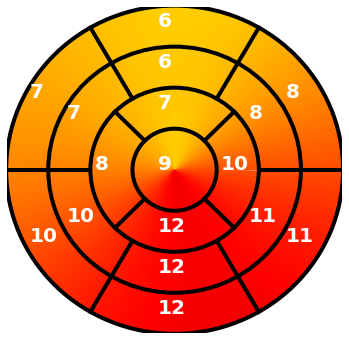

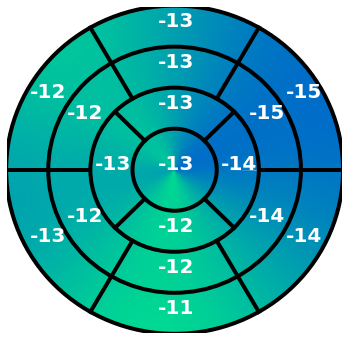

Borrando el archivo fig5.png
Borrando el archivo fig2.png
Borrando el archivo fig8.png
Borrando el archivo fig3.png
Borrando el archivo fig6.png
Borrando el archivo fig1.png
Borrando el archivo fig7.png
Borrando el archivo fig4.png
... radial strain
(14, 128, 128)
... circumferential strain
(14, 128, 128)


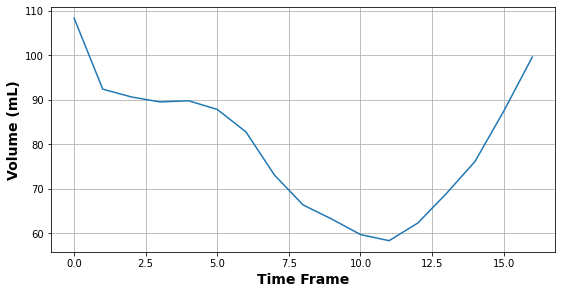

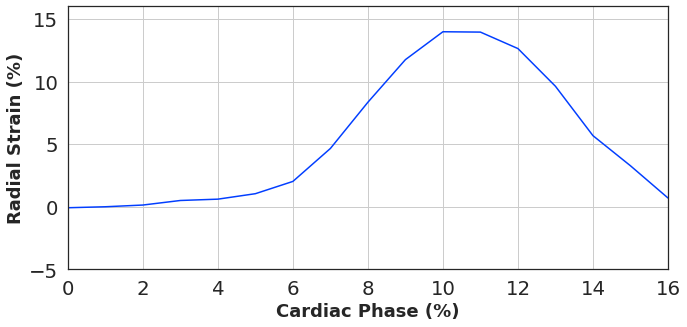

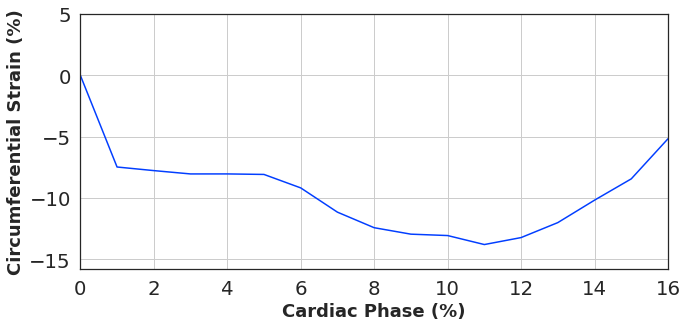

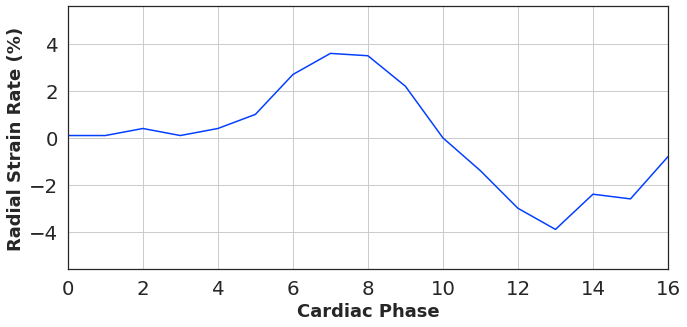

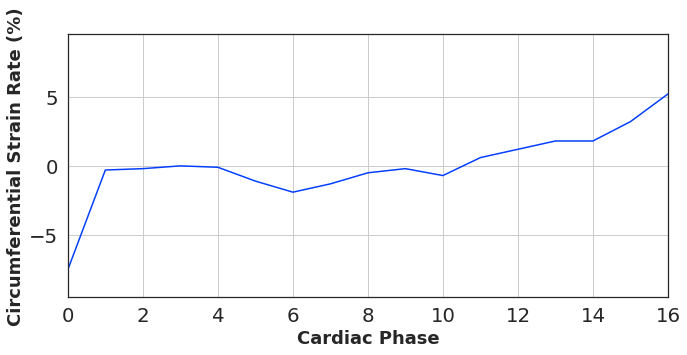

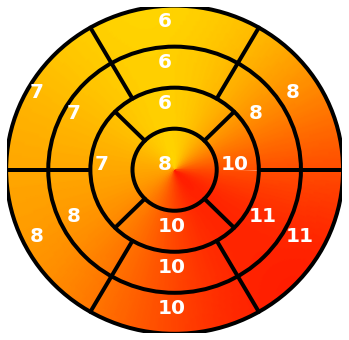

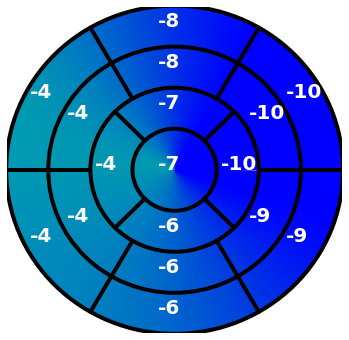

Borrando el archivo fig5.png
Borrando el archivo fig2.png
Borrando el archivo fig8.png
Borrando el archivo fig3.png
Borrando el archivo fig6.png
Borrando el archivo fig1.png
Borrando el archivo fig7.png
Borrando el archivo fig4.png
... radial strain
(9, 128, 128)
... circumferential strain
(9, 128, 128)


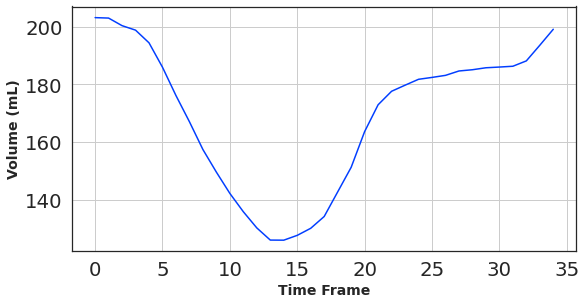

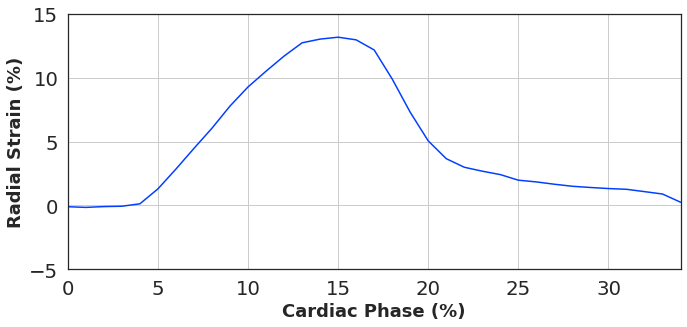

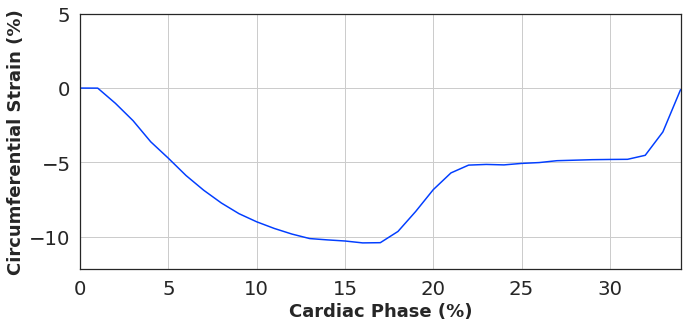

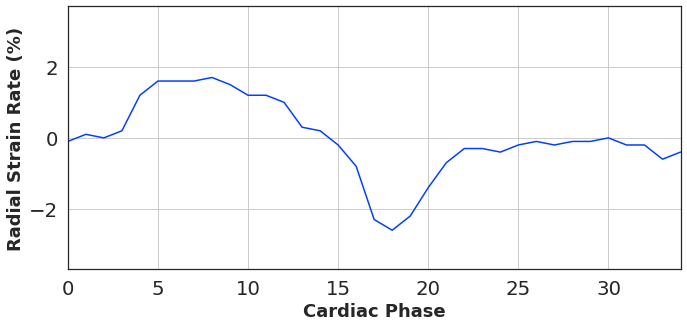

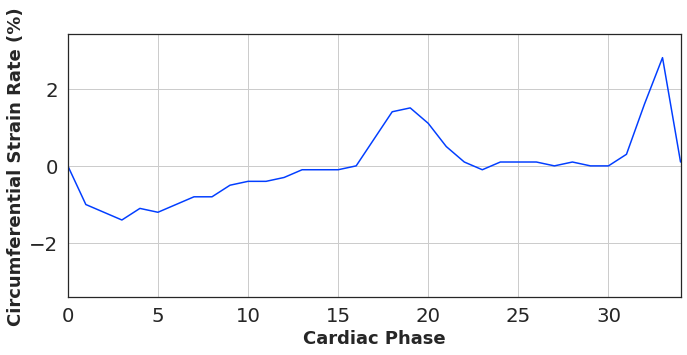

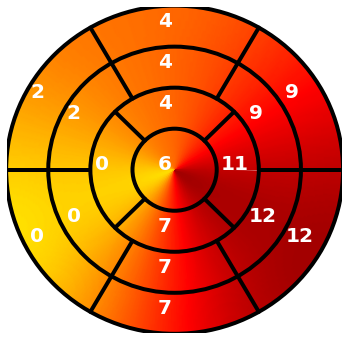

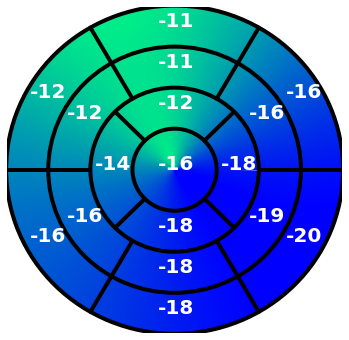

Borrando el archivo fig5.png
Borrando el archivo fig2.png
Borrando el archivo fig8.png
Borrando el archivo fig3.png
Borrando el archivo fig6.png
Borrando el archivo fig1.png
Borrando el archivo fig7.png
Borrando el archivo fig4.png


/local_mount/space/celer/1/users/notebooks/angel/Deepstrain_Angel/data/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


... radial strain
(6, 128, 128)
... circumferential strain
(6, 128, 128)


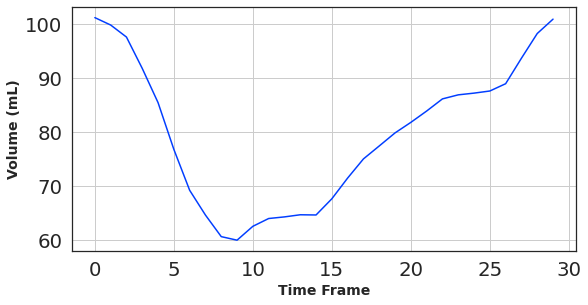

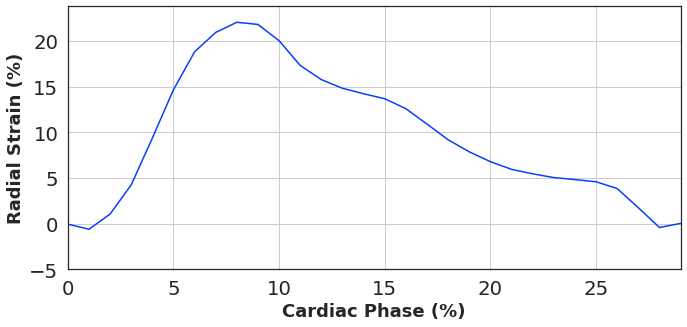

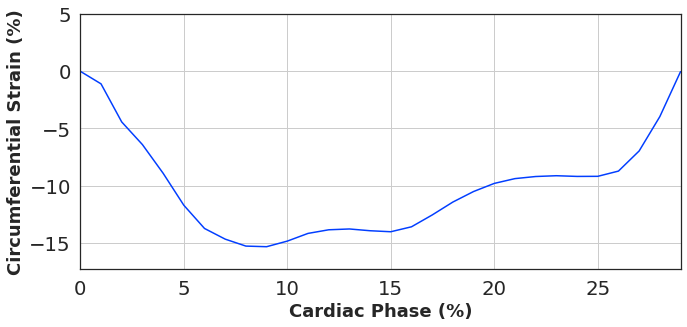

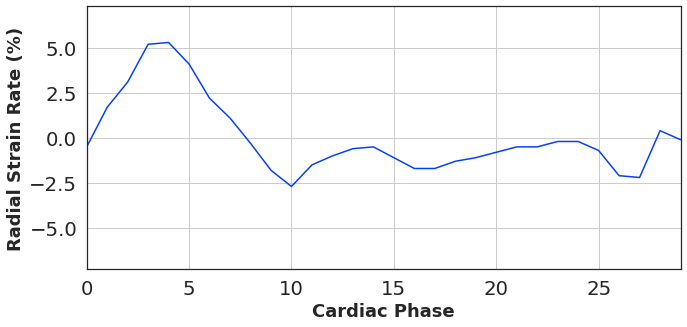

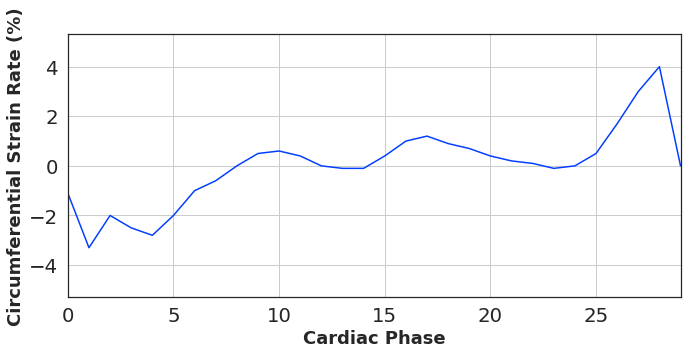

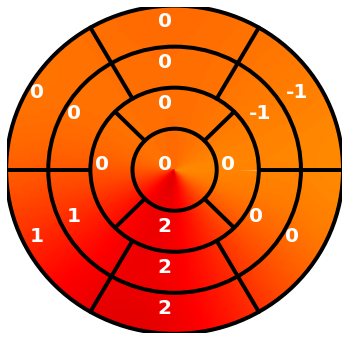

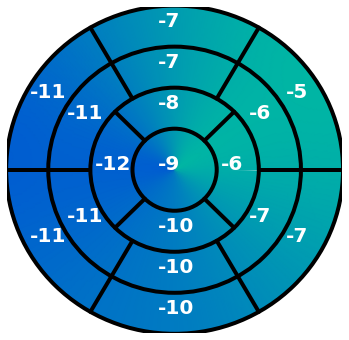

Borrando el archivo fig5.png
Borrando el archivo fig2.png
Borrando el archivo fig8.png
Borrando el archivo fig3.png
Borrando el archivo fig6.png
Borrando el archivo fig1.png
Borrando el archivo fig7.png
Borrando el archivo fig4.png


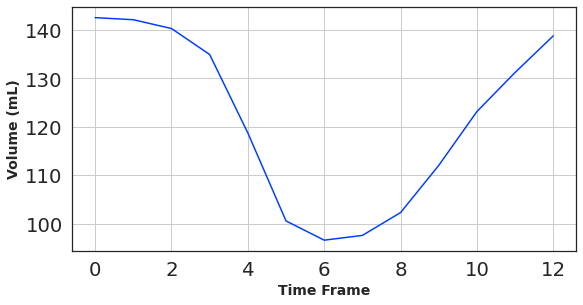

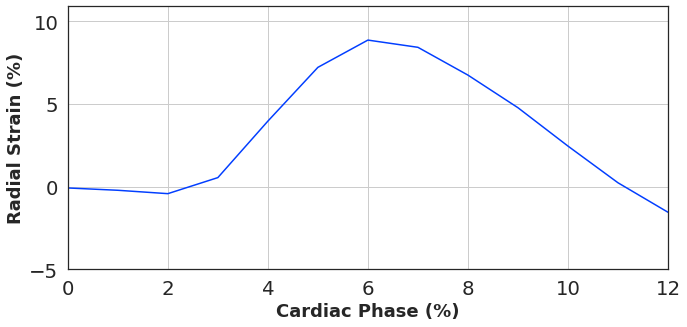

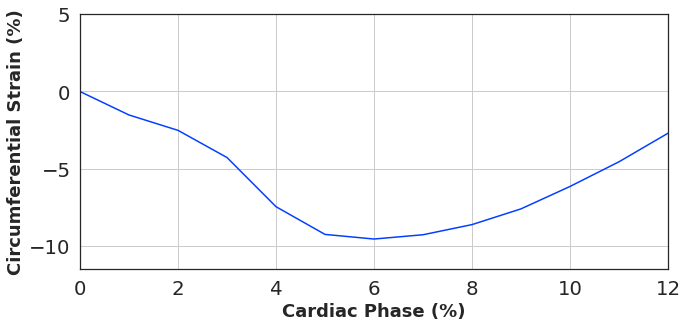

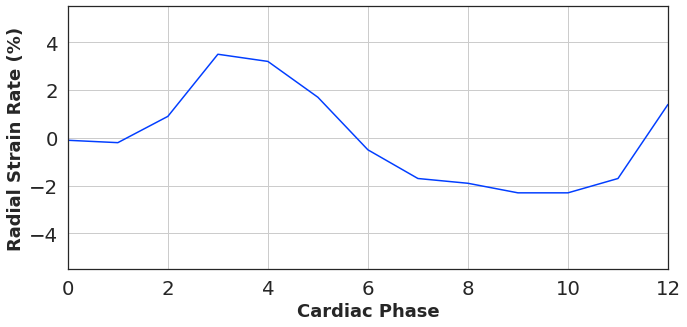

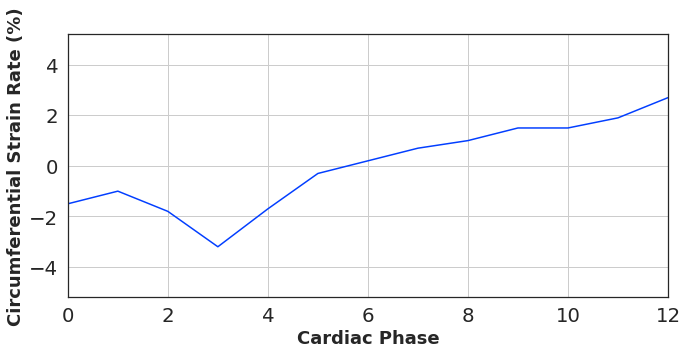

In [13]:
for niftifile in os.listdir(opt.datadir):

    V_nifti = nib.load(os.path.join(opt.datadir, niftifile))
    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=None)  

    V = V_nifti_resampled.get_fdata()
    V = normalize(V, axis=(0,1))

    M = get_mask(V) 

    if False:
        M_nifti_resampled = nib.Nifti1Image(M, affine=V_nifti_resampled.affine)
        M_nifti = base_dataset.resample_nifti_inv(nifti_original=M_nifti_resampled, 
                                                      zooms=M_nifti_resampled.header.get_zooms()[:3], 
                                                      order=0, mode='nearest')    
    else:

        M = get_mask(V)

        center_resampled = center_of_mass(M[:,:,:,0]==2)
        V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
        M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
        center_resampled_256x256 = center_of_mass(M==3)

        nifti_info = {'affine'           : V_nifti.affine,
                        'affine_resampled' : V_nifti_resampled.affine,
                        'zooms'            : V_nifti.header.get_zooms(),
                        'zooms_resampled'  : V_nifti_resampled.header.get_zooms(),
                        'shape'            : V_nifti.shape,
                        'shape_resampled'  : V_nifti_resampled.shape,
                        'center_resampled' : center_resampled,
                        'center_resampled_256x256' : center_resampled_256x256} 

        M = get_mask(V)[128-64:128+64,128-64:128+64]
        M_nifti = base_dataset.convert_back_to_nifti(M, nifti_info, inv_256x256=True, order=1, mode='nearest')


    volumes=((M_nifti.get_fdata()==3).sum(axis=(0,1,2))*np.prod(M_nifti.header.get_zooms()[:3])/1000)
    EDias=(volumes.argmax())
    ESist=(volumes.argmin())


    M_params = M_nifti.get_fdata()
    resolution_params = M_nifti.header.get_zooms()[:3]
    params = metrics.get_clinical_parameters(M_ed=M_params[...,EDias], M_es=M_params[...,ESist], voxel_spacing_mm=resolution_params)


    paramsPD = pd.DataFrame.from_dict(params).round(1)
    DF_rowname=niftifile.rstrip(".nii.gz")
    paramsPD.insert(0, "ID", [DF_rowname], True)

    frames=(len(volumes))


    # Motion estimation (with rearrange method)


    newnifti_V=nib.funcs.concat_images((V_nifti, V_nifti), axis=3)
    newnifti_M=nib.funcs.concat_images((M_nifti, M_nifti), axis=3)

    sliced_M=newnifti_M.get_fdata()
    sliced_V=newnifti_V.get_fdata()

    clipped_M=sliced_M[:,:,:,EDias:(EDias+frames)]
    clipped_V=sliced_V[:,:,:,EDias:(EDias+frames)]

    clipped_NIFTI_M=nib.Nifti1Image(clipped_M, M_nifti.header.get_base_affine(), M_nifti.header)
    clipped_NIFTI_V=nib.Nifti1Image(clipped_V, V_nifti.header.get_base_affine(), V_nifti.header) 

    volumes_ordered=((clipped_NIFTI_M.get_fdata()==3).sum(axis=(0,1,2))*np.prod(clipped_NIFTI_M.header.get_zooms()[:3])/1000)

    EDias_=(volumes_ordered.argmax())
    ESist_=(volumes_ordered.argmin())

    df_ =  {'Frame':[], 'Radial Strain':[], 'Circumferential Strain':[]}
    df__ = {'Radial Strain':[], 'Circumferential Strain':[]}

    ES_ = ESist_
    ED_ = EDias_

    V_nifti2 = clipped_NIFTI_V
    M_nifti2 = clipped_NIFTI_M

    V_nifti_resampled_ = resample_nifti(V_nifti2, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
    M_nifti_resampled_ = resample_nifti(M_nifti2, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)

    center_ = center_of_mass(M_nifti_resampled_.get_fdata()[:,:,:,ED_]==2)
    V_ = _roll2center_crop(x=V_nifti_resampled_.get_fdata(), center=center_)
    M_ = _roll2center_crop(x=M_nifti_resampled_.get_fdata(), center=center_)

    I_ = np.argmax((M_==1).sum(axis=(0,1,3)))
    if I_ > M_.shape[2]//2:
        V_ = V_[:,:,::-1]
        M_ = M_[:,:,::-1]

    V_ = normalize(V_, axis=(0,1,2))

    mask_end_diastole_ = M_[..., ED_] 

    Errr  = np.zeros((128,128,16,frames))
    Eccc  = np.zeros((128,128,16,frames))  

    for i in range(frames):
        V_0_ = V_[...,ED_][None,...,None]
        V_t_ = V_[...,i][None,...,None]


        y_t_ = netME([V_0_, V_t_]).numpy()
        y_t_ = gaussian_filter(y_t_, sigma=(0,2,2,0,0))


        strain_ = myocardial_strain.MyocardialStrain(mask=mask_end_diastole_, flow=y_t_[0,:,:,:,:])
        strain_.calculate_strain(lv_label=2)


        Errr[:,:,:,i] += strain_.Err
        Eccc[:,:,:,i] += strain_.Ecc


        df_['Frame']                   += [i]
        df_['Radial Strain']           += [100*strain_.Err[strain_.mask_rot==2].mean()]
        df_['Circumferential Strain']  += [100*strain_.Ecc[strain_.mask_rot==2].mean()]

        if i == ESist_:
            df__['Radial Strain']           += [100*strain_.Err[strain_.mask_rot==2].mean()]
            df__['Circumferential Strain']  += [100*strain_.Ecc[strain_.mask_rot==2].mean()]

    df_  = pd.DataFrame(df_)
    df__ = pd.DataFrame(df__)


    df_m= df_.round(1)

    df_list= df_m.values.tolist()
    df_list_m = df_list.copy()

    df_list_m.insert(len(df_list_m), df_list_m.pop(0))


    radlist=[]
    circlist=[]
    radlist_m=[]
    circlist_m=[]
    frame=[]

    for i in df_list:
        radlist.append(i[1])
        circlist.append(i[2])

    for i in df_list_m:
        radlist_m.append(i[1])
        circlist_m.append(i[2])

    for i in df_list:
        frame.append(i[0])


    RadialRate = []
    CircRate = []

    for (item1, item2) in zip(radlist_m, radlist):
        RadialRate.append(item1-item2)

    for (item1, item2) in zip(circlist_m, circlist):
        CircRate.append(item1-item2)


    Radialtuple = list(zip(frame, RadialRate))
    Circtuple = list(zip(frame, CircRate))

    RadialRate_ = pd.DataFrame(Radialtuple, columns=["Frame", "Radial Strain Rate"])
    CircRate_ = pd.DataFrame(Circtuple, columns=["Frame", "Circumferential Strain Rate"])


    rounded_strain = df__.round(1)
    fig1 = paramsPD.join(rounded_strain)

    dfi.export(fig1, 'temp/fig1.png')

    if os.path.exists("./Results/Parameters.csv") == True:
        fig1.to_csv("./Results/Parameters.csv", mode='a', header = False)
    else:
        fig1.to_csv("./Results/Parameters.csv")


    # Regional strain maps

    Errr__  = Errr[:,:,::-1, ES_]
    Eccc__  = -Eccc[:,:,::-1, ES_]
    maskk__ = mask_end_diastole_[:,:,::-1]

    start=ED_
    stop=ES_

    maskk__[:,:,:start] = 0
    maskk__[:,:,stop:]  = 0

    polarmap  = myocardial_strain.PolarMap(Errr__,Eccc__,maskk__)
    results_maps = polarmap.project_to_aha_polar_map()

    map_err, mu_err = polarmap.construct_polar_map(results_maps['V_err'], start=30, stop=70, sigma=15)
    map_ecc, mu_ecc = polarmap.construct_polar_map(results_maps['V_ecc'], start=30, stop=70, sigma=15)

    err_max=(map_err.max().round(1)*100)
    err_min=(map_err.min().round(1)*100)
    ecc_max=(map_ecc.max().round(1)*100)
    ecc_min=(map_ecc.min().round(1)*100)

    current_palette = sns.color_palette()
    current_palette = [(0,0,0)] + current_palette


    savepath="temp/fig2.png"
    myocardial_strain.plot_bullseye(map_err, mu_err[1:], 
                                    vmin=(err_min-10), vmax=(err_max+10),cmap='hot_r',
                                    savepath=savepath, label='Radial Strain (%)',cbar=False)


    savepath2="temp/fig3.png"
    myocardial_strain.plot_bullseye(-map_ecc, -np.array(mu_ecc)[1:], 
                                    vmin=(-ecc_min-10), vmax=(-ecc_max+10), cmap='winter', 
                                    savepath=savepath2, label='Circumferential Strain (%)',cbar=False)


    fig_ = plt.gcf()

    fig4=plt.plot((clipped_NIFTI_M.get_fdata()==3).sum(axis=(0,1,2))*np.prod(clipped_NIFTI_M.header.get_zooms()[:3])/1000)
    fig_.set_size_inches(10, 5)
    plt.xlabel('Time Frame', weight='bold', fontsize=14)
    plt.ylabel('Volume (mL)', weight='bold', fontsize=14)
    plt.grid()
    plt.gcf().subplots_adjust(left=0.2, bottom=0.2)
    plt.savefig("./temp/fig4.png", dpi=200)


    fig5 = plt.figure(figsize=(10,5))
    sns.set(style='white', font_scale=1.8, palette="bright")
    sns.lineplot(x="Frame", y="Radial Strain", data=df_, palette=current_palette[:5]); 
    plt.ylabel('Radial Strain (%)', weight='bold', fontsize=18)
    plt.xlabel('Cardiac Phase (%)', weight='bold', fontsize=18)
    plt.xlim(0,frames-1)
    plt.ylim(-5,fig1.iloc[0,8]+2)
    plt.tight_layout()
    plt.grid()
    plt.savefig("./temp/fig5.png")


    fig6 = plt.figure(figsize=(10,5))
    sns.set(style='white', font_scale=1.8, palette="bright")
    sns.lineplot(x="Frame", y="Circumferential Strain", data=df_, palette=current_palette[:5]); 
    plt.ylabel('Circumferential Strain (%)', weight='bold', fontsize=18)
    plt.xlabel('Cardiac Phase (%)', weight='bold', fontsize=18)
    plt.xlim(0,frames-1)
    plt.ylim(fig1.iloc[0,9]-2,5)
    plt.tight_layout()
    plt.grid()
    plt.savefig("./temp/fig6.png")


    # Generate strain rate polar curves


    fig7 = plt.figure(figsize=(10,5))
    sns.set(style='white', font_scale=1.8, palette="bright")
    sns.lineplot(x="Frame", y="Radial Strain Rate", data=RadialRate_, palette=current_palette[:5]); 
    plt.ylabel('Radial Strain Rate (%)', weight='bold', fontsize=18)
    plt.xlabel('Cardiac Phase', weight='bold', fontsize=18)
    plt.xlim(0,frames-1)
    plt.ylim((max(RadialRate)+2)*-1,max(RadialRate)+2)
    plt.tight_layout()
    plt.grid()
    plt.savefig("./temp/fig7.png")


    fig8 = plt.figure(figsize=(10,5))
    sns.set(style='white', font_scale=1.8, palette="bright")
    sns.lineplot(x="Frame", y="Circumferential Strain Rate", data=CircRate_, palette=current_palette[:5]); 
    plt.ylabel('Circumferential Strain Rate (%)', weight='bold', fontsize=18)
    plt.xlabel('Cardiac Phase', weight='bold', fontsize=18)
    plt.xlim(0,frames-1)
    plt.ylim(min(CircRate)-2, (min(CircRate)-2)*-1)
    plt.tight_layout()
    plt.grid()
    plt.savefig("./temp/fig8.png")


    # Create the PDF


    pdf = FPDF()
    pdf.add_page()

    pdf.set_font("Arial", size = 32)
    pdf.set_xy(10,15)
    pdf.cell(0, txt = "Results", ln = 0, align = 'C')

    pdf.image("temp/fig1.png", w=180, h=13, x=15, y=25)
    pdf.image("temp/fig4.png", w=90, h=55, x=2, y=40)
    pdf.image("temp/fig5.png", w=75, h=50, x=10, y=105)
    pdf.image("temp/fig7.png", w=75, h=50, x=100, y=105)
    pdf.image("temp/fig6.png", w=75, h=50, x=10, y=160)
    pdf.image("temp/fig8.png", w=75, h=50, x=100, y=160)
    pdf.image("temp/fig2.png", w=75, h=75, x=15, y=220)
    pdf.image("temp/fig3.png", w=75, h=75, x=105, y=220)
    pdf.set_xy(10,218)
    pdf.set_font("Arial", size = 12)
    pdf.cell(100, 5, txt = "                      Radial Strain (%)                                           Circumferential Strain (%)", ln = 1, align = 'c')
    pdf.line(1,1,209,1)
    pdf.line(1,1,1,296)
    pdf.line(1,296,209,296)
    pdf.line(209,1,209,296)

    pdf.line(3,3,207,3)
    pdf.line(3,3,3,294)
    pdf.line(3,294,207,294)
    pdf.line(207,3,207,294)

    pdf.set_line_width(0.4)
    pdf.line(85,20,125,20)


    pdf.output("./Results/{}.pdf".format(niftifile)) 
    
    for tempfile in os.listdir(path_temp):
        print("Borrando el archivo {}".format(tempfile))
        os.remove(os.path.join(path_temp, tempfile))

In [14]:
shutil.rmtree("./temp", ignore_errors=True)